In [1]:
import sys
import subprocess
import pkg_resources
import statsmodels._version

if statsmodels._version.get_versions()['version'] != '0.11.1':
  !pip install --upgrade statsmodels

required = {'pmdarima'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%cd "/content/drive/My Drive/Colab Notebooks/Time_Series_Projects/Data"

/content/drive/My Drive/Colab Notebooks/Time_Series_Projects/Data


In [33]:
from statsmodels.tsa.api import VAR

In [4]:
df1 = pd.read_csv('M2SLMoneyStock.csv',parse_dates=True,index_col = 0)
df2 = pd.read_csv('PCEPersonalSpending.csv',parse_dates=True,index_col = 0)

In [7]:
df = df1.join(df2)

In [10]:
df.index.freq = 'MS'

In [11]:
df.dropna(inplace=True)

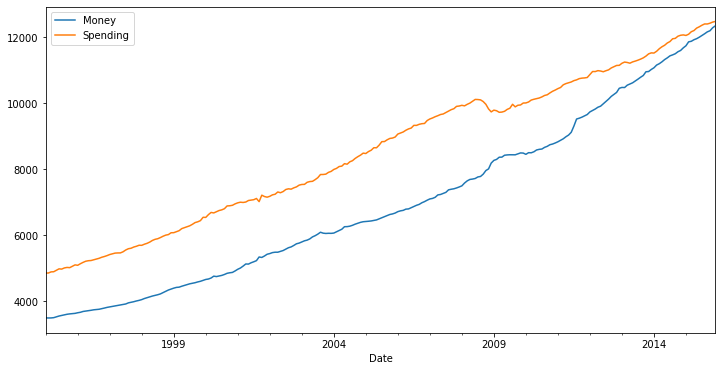

In [12]:
df.plot(figsize=(12,6))

### Function for running the augmented Dickey-Fuller test
Since we'll use it frequently in the upcoming forecasts, let's define a function we can copy into future notebooks for running the augmented Dickey-Fuller test. Remember that we'll still have to import <tt>adfuller</tt> at the top of our notebook.

In [13]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    print('\nResult:')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [14]:
adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044

Result:
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [15]:
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019

Result:
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [17]:
df_transf = df.diff()

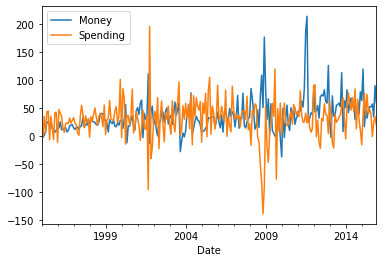

In [20]:
df_transf.plot()

In [18]:
adf_test(df_transf['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367

Result:
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [19]:
adf_test(df_transf['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00

Result:
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [21]:
df_transf = df_transf.diff().dropna()

In [23]:
adf_test(df_transf['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00

Result:
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [24]:
adf_test(df_transf['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00

Result:
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


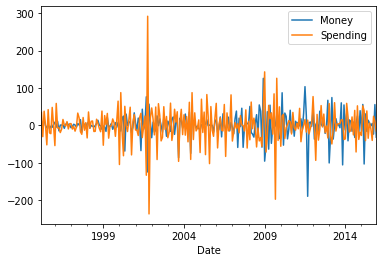

In [25]:
df_transf.plot()

In [26]:
df_transf.shape

(250, 2)

In [27]:
nobs = 12

In [28]:
train = df_transf[:-nobs]
test = df_transf[-nobs:]

Grid Search for order p AR of VAR model

In [36]:
model = VAR(train)
for p in [1,2,3,4,5,6,7]:
  results = model.fit(p)
  print(f'Order {p}')
  print(f'AIC: {results.aic:.2f}')
  print('\n')

Order 1
AIC: 14.18


Order 2
AIC: 13.96


Order 3
AIC: 13.85


Order 4
AIC: 13.83


Order 5
AIC: 13.79


Order 6
AIC: 13.80


Order 7
AIC: 13.80




In [39]:
results = model.fit(5)

In [41]:
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 06, Jul, 2020
Time:                     03:58:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

In [42]:
#grab the 5 lagged values before test starts in nparray

In [44]:
lagged_values = train[-5:].values

In [46]:
z =results.forecast(y = lagged_values, steps = nobs)

In [47]:
idx = pd.date_range('2015-01-01',periods=nobs,freq = 'MS')

In [64]:
df_forecast = pd.DataFrame(data=z,index=idx, columns=['Money_2D','Spending_2D']) #or pd.DataFrame(data=z,index=test.index, columns=['Money_2D','Spending_2D'])

In [73]:
df_forecast

,Money_2D,Spending_2D,Money_1D,Money_Forecast,Spending_1D,Spending_Forecast
2015-01-01,-16.995276,36.149820,8033.204724,19703.304724,7042.549820,19104.549820
2015-02-01,-3.174038,-11.450298,8030.030686,27733.335410,7031.099522,26135.649342
2015-03-01,-0.377725,-6.684969,8029.652961,35762.988371,7024.414552,33160.063894
2015-04-01,-2.602233,5.479458,8027.050728,43790.039099,7029.894010,40189.957904
2015-05-01,4.228557,-2.443365,8031.279285,51821.318384,7027.450645,47217.408549
2015-06-01,1.559393,0.387639,8032.838678,59854.157062,7027.838284,54245.246833
2015-07-01,-0.998410,3.883680,8031.840268,67885.997331,7031.721964,61276.968797
2015-08-01,0.364510,-2.356101,8032.204779,75918.202109,7029.365863,68306.334659
2015-09-01,-1.210627,-1.224147,8030.994151,83949.196261,7028.141716,75334.476375
2015-10-01,0.225877,0.786927,8031.220028,91980.416289,7028.928643,82363.405019


In [78]:
df_forecast['Money_1D'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2])+df_forecast['Money_2D'].cumsum()
df_forecast['Money_Forecast'] = df['Money'].iloc[-nobs-1]+df_forecast['Money_1D'].cumsum()

df_forecast['Spending_1D'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2])+df_forecast['Spending_2D'].cumsum()
df_forecast['Spending_Forecast'] = df['Spending'].iloc[-nobs-1]+df_forecast['Spending_1D'].cumsum()

In [80]:
df_forecast.head()

,Money_2D,Spending_2D,Money_1D,Money_Forecast,Spending_1D,Spending_Forecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


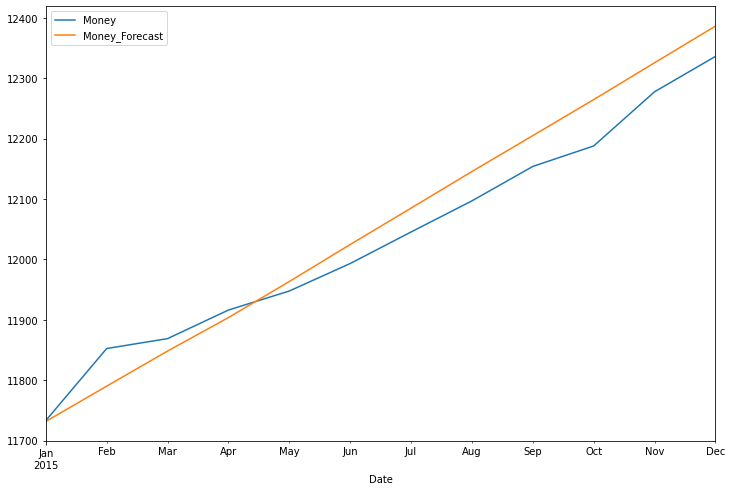

In [87]:
df.iloc[-nobs:]['Money'].plot(figsize = (12,8),legend = True)
df_forecast['Money_Forecast'].plot(legend = True)

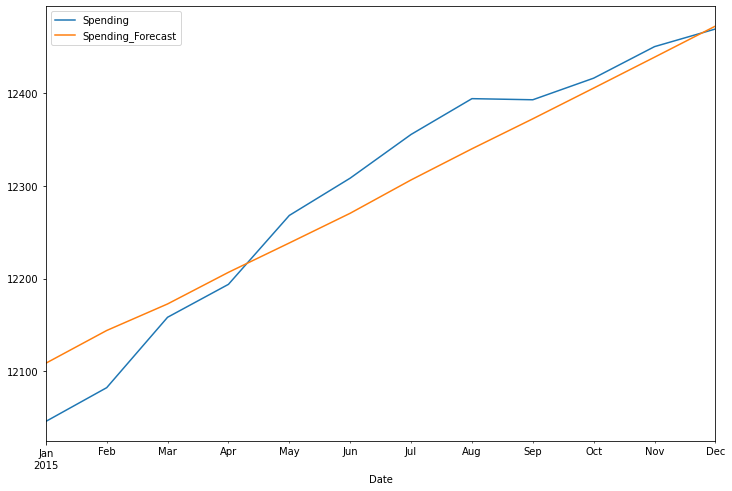

In [88]:
df.iloc[-nobs:]['Spending'].plot(figsize = (12,8),legend = True)
df_forecast['Spending_Forecast'].plot(legend = True)

In [90]:
from statsmodels.tools.eval_measures import rmse

In [97]:
rmse(df[-nobs:]['Spending'],df_forecast['Spending_Forecast'])
print(f"Spending Mean: {df[-nobs:]['Spending'].mean():.0f} and RMSE: {rmse(df[-nobs:]['Spending'],df_forecast['Spending_Forecast']):.0f})")

Spending Mean: 12295 and RMSE: 37)


In [98]:
rmse(df[-nobs:]['Money'],df_forecast['Money_Forecast'])
print(f"Money Mean: {df[-nobs:]['Money'].mean():.0f} and RMSE: {rmse(df[-nobs:]['Money'],df_forecast['Money_Forecast']):.0f})")

Money Mean: 12034 and RMSE: 44)


Forecasting into the future

In [99]:
model = VAR(df_transf)
result = model.fit(5)

In [ ]:
result.forecast()

In [100]:
lagged_values = df_transf[-5:].values

In [101]:
z =results.forecast(y = lagged_values, steps = nobs)

In [103]:
idx = pd.date_range('2016-01-01',periods=nobs,freq = 'MS')

In [104]:
df_forecast = pd.DataFrame(data=z,index=idx, columns=['Money_2D','Spending_2D']) #or pd.DataFrame(data=z,index=test.index, columns=['Money_2D','Spending_2D'])

In [106]:
df_forecast.head(2)

,Money_2D,Spending_2D
2016-01-01,-6.073043,5.200759
2016-02-01,14.688110,1.514034


In [112]:
df_forecast['Money_1D'] = (df['Money'].iloc[-1]-df['Money'].iloc[-2])+df_forecast['Money_2D'].cumsum()
df_forecast['Money_Forecast'] = df['Money'].iloc[-1]+df_forecast['Money_1D'].cumsum()

df_forecast['Spending_1D'] = (df['Spending'].iloc[-1]-df['Spending'].iloc[-2])+df_forecast['Spending_2D'].cumsum()
df_forecast['Spending_Forecast'] = df['Spending'].iloc[-1]+df_forecast['Spending_1D'].cumsum()

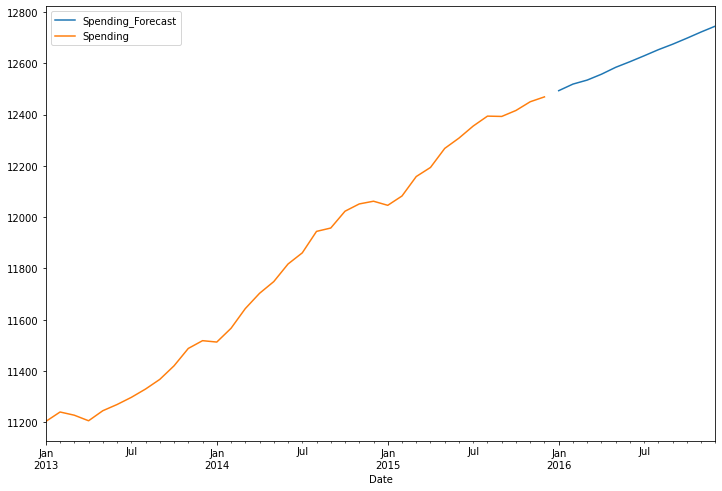

In [119]:
df_forecast['Spending_Forecast'].plot(figsize = (12,8),legend = True)
df[-36:]['Spending'].plot(legend = True)

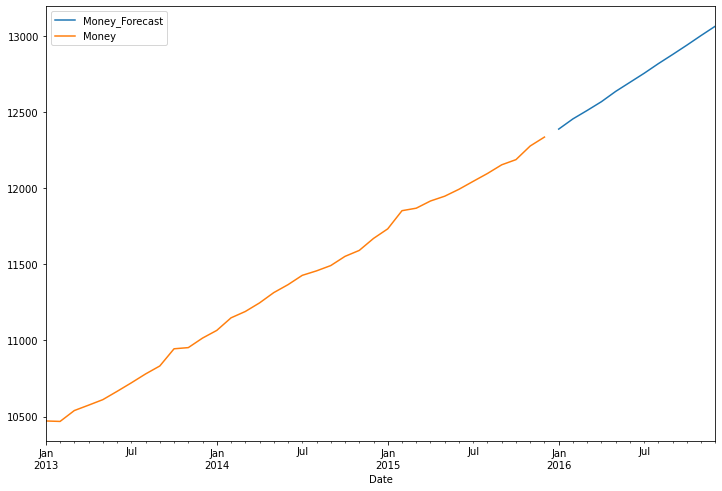

In [120]:
df_forecast['Money_Forecast'].plot(figsize = (12,8),legend = True)
df[-36:]['Money'].plot(legend = True)